# Interaction between objects

This notebook shows you how different objects in GeNePy3D can work together to provide insights from your data. You can download the notebook [here](https://gitlab.com/genepy3d/genepy3d.gitlab.io/-/blob/master/source/interaction_objects.ipynb). We are going to analyze some data from [Kunst's paper ](https://www.cell.com/neuron/pdfExtended/S0896-6273(19)30391-5), which constructs an atlas of over 2000 neurons across various brain regions of the larval zebrafish. Here, we use GeNePy3D to analyze a subset of neurons initializing from Retina toward Tectum in the zebrafish brain. Let's first import the 3D image stack containing labels of different brain regions.

## Import image stack of brain regions

In [1]:
import nrrd
import numpy as np

regions, _ = nrrd.read('data/MPIN-Atlas.nrrd')
regions = np.swapaxes(regions,0,2) # swap axes to the ZYX order
print('shape (Z, Y, X):',regions.shape)

shape (Z, Y, X): (359, 974, 597)


## Extract surfaces of Retina and Tectum

To extract the 3D surface from a labeled volume, GeNePy3D provides ``from_volume()`` constructor which employs [marching cube algorithm](https://scikit-image.org/docs/stable/auto_examples/edges/plot_marching_cubes.html). We compute from the image stack *regions* the surface of Retina (label = 28) and the surface of Tectum (label = 30) with a step size = 20. A larger step size produces coarser 3D mesh but faster computation time.

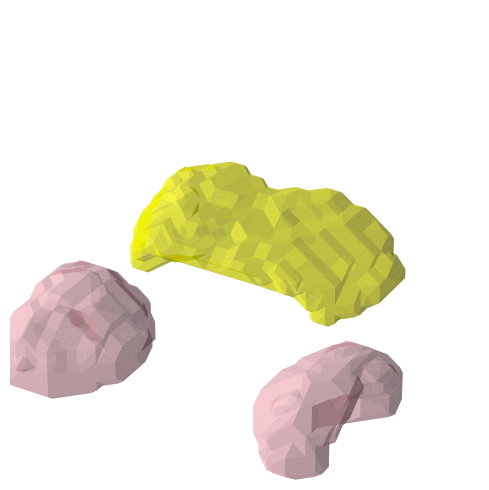

In [2]:
from genepy3d.obj import surfaces
import matplotlib.pyplot as plt

# Import Retina and Tectum surfaces
retina_surf = surfaces.Surface.from_volume(regions,lbl=28,step_size=20)
tectum_surf = surfaces.Surface.from_volume(regions,lbl=30,step_size=20)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

retina_surf.plot(ax,args_3d={'color':'pink','alpha':0.5});
tectum_surf.plot(ax,args_3d={'color':'yellow','alpha':0.5});

ax.axis('off');
plt.tight_layout();

## Import neurons

Then, we import some retinal ganglion neurons from their .swc files. GeNePy3D provides ``swc`` module to handle this file format.

In [3]:
from genepy3d.io import swc

# Import neuronal traces from SWC files
filepath = "data/retinal_ganglion_cells/"
f = swc.SWC(filepath,recursive=True)

neuidlst = f.get_neuron_id().values
print("nb. of imported neurons:",len(neuidlst))

nb. of imported neurons: 10


Let's plot all together.

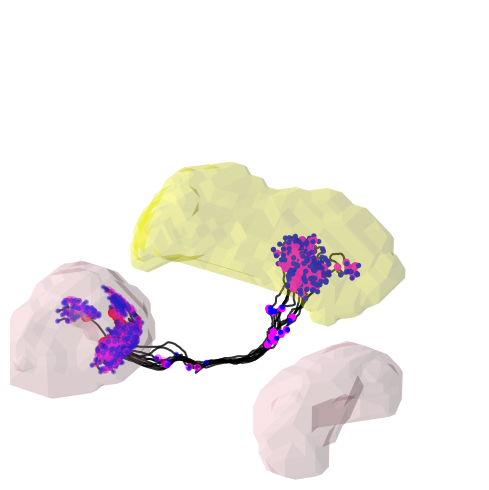

In [4]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for neuid in neuidlst:
    neuron = f.get_neurons(neuid)
    neuron.plot(ax)

retina_surf.plot(ax,args_3d={'color':'pink','alpha':0.2});
tectum_surf.plot(ax,args_3d={'color':'yellow','alpha':0.2});

ax.axis('off');
plt.tight_layout();

## Split left and right Retina

In this particular example, only the neurons coming from the left Retina is used. We can take only the left Retina surface for the analysis by using ``split()`` function. If the surface consists of distinct regions, then the function returns the surfaces of these regions.

In [5]:
retina_surf1, retina_surf2 = retina_surf.split()

Here, the ``retina_surf1`` is the Retina on the left side. 

## Extract axon traces

Next, we only interested in the axon-like portion of the neuron and would like to study how curvy it is when it stays within the Retina or within the Tectum. The axon-like portion is the longest trace from the root node toward a leaf node of the neuron and can be extracted from ``compute_spine()`` function.

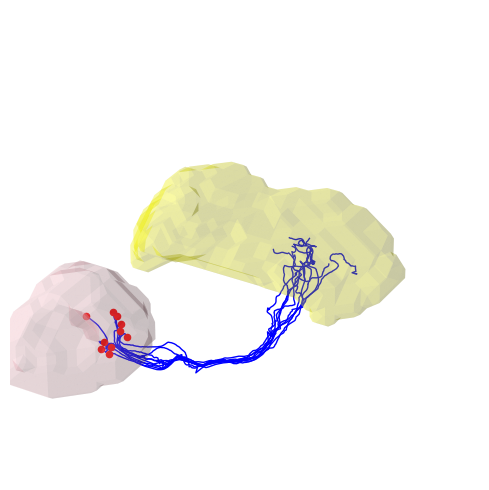

In [6]:
spine_lst = []

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for neuid in neuidlst:
    neuron = f.get_neurons(neuid)
    spine = neuron.to_curve(neuron.compute_spine()) # extract the spine of the neuron
    spine_lst.append(spine)
    spine.plot(ax)

retina_surf1.plot(ax,args_3d={'color':'pink','alpha':0.2});
tectum_surf.plot(ax,args_3d={'color':'yellow','alpha':0.2});

ax.axis('off');
plt.tight_layout();

## Get axon portions inside Retina or Tectum

Now, to get the fraction of axon trace that is inside the Retina or the Tectum, let's use ``inonout()`` function from module ``curvesurface``. This function returns trace portions that are inside, onside or outside of a given surface.

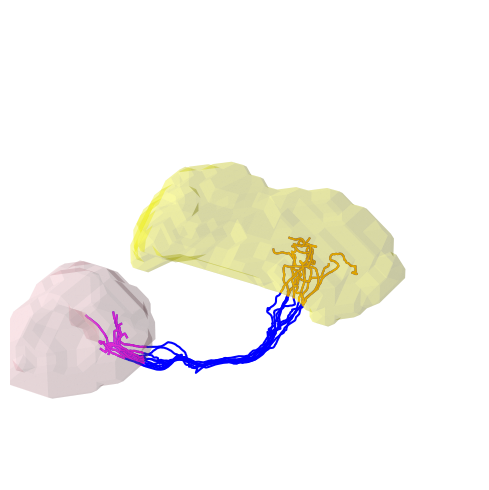

In [7]:
from genepy3d_gpl.interact import curvesurface

spine_in_retina_lst = []
spine_in_tectum_lst = []

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111,projection="3d")

for spine in spine_lst:

    spine.plot(ax,show_root=False,line_args={'c':'blue'})
    
    spine_in_retina, _, _ = curvesurface.inonout(spine,retina_surf1) # get fraction inside of Retina
    spine_in_retina[0].plot(ax,show_root=False,line_args={'c':'magenta'})
    spine_in_retina_lst.append(spine_in_retina[0])
    
    spine_in_tectum, _, _ = curvesurface.inonout(spine,tectum_surf) # get fraction inside of Tectum
    spine_in_tectum[0].plot(ax,show_root=False,line_args={'c':'orange'})
    spine_in_tectum_lst.append(spine_in_tectum[0])

retina_surf1.plot(ax,args_3d={'color':'pink','alpha':0.2});
tectum_surf.plot(ax,args_3d={'color':'yellow','alpha':0.2});

ax.axis('off');
plt.tight_layout();

## Measure the wiggliness

Finally, we compute the wiggliness (or curviness) of axon portions inside of the Retina and the Tectum.

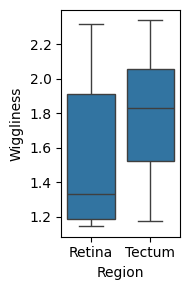

In [8]:
import seaborn as sns
import pandas as pd

# Compute the curviness of portions within the Retina
spine_in_retina_wigg = []
for spine_in_retina in spine_in_retina_lst:
    spine_in_retina_wigg.append(spine_in_retina.compute_wiggliness())

# Compute the curviness of portions within the Tectum
spine_in_tectum_wigg = []
for spine_in_tectum in spine_in_tectum_lst:
    spine_in_tectum_wigg.append(spine_in_tectum.compute_wiggliness())

# Build a dataframe to plot the result
values = spine_in_retina_wigg + spine_in_tectum_wigg
regions = ['Retina' for _ in spine_in_retina_wigg] + ['Tectum' for _ in spine_in_tectum_wigg]
table = pd.DataFrame({'Region':regions,'Wiggliness':values})

fig = plt.figure(figsize=(2,3))
ax = fig.add_subplot(111)
sns.boxplot(x='Region',y='Wiggliness',data=table);
plt.tight_layout();

Regarding the result, the axons are likely more wiggly when they arrive the Tectum than when they originate from the Retina.